<a href="https://colab.research.google.com/github/Adarsh63/hello-project/blob/main/tweet_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Download the  pretrained fastText
* preprocessing done using word embading 


*FastText pre-trained word vectors for 157 languages, trained on Common Crawl and Wikipedia using fastText. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives.

In [ ]:
#pull the pretrained model 
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
#from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.
sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

2454it [00:00, 12616.29it/s]

loading word embeddings...


1999996it [02:59, 11112.54it/s]

found 1999996 word vectors


In [ ]:
#load the data
train = pd.read_csv("/content/drive/MyDrive/nlp_tweeter/train.csv")
test = pd.read_csv("/content/drive/MyDrive/nlp_tweeter/test.csv")
print("Number of training data ", train.shape[0])
print("Number of testing data: ", test.shape[0])

Number of training data  7613
Number of testing data:  3263


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


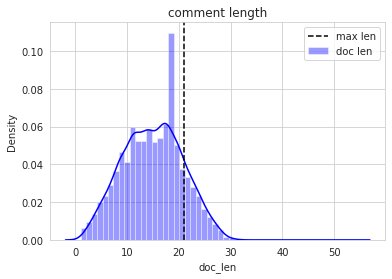

In [ ]:
label_names = ["target"]
y_train = train[label_names].values
train['doc_len'] = train['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)

#plot shows the distribution of the sentance lenth 
sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [ ]:
from sklearn.utils import shuffle 

raw_docs_train = train['text'].tolist()
raw_docs_test = test['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for train

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for test 

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  8%|▊         | 584/7613 [00:00<00:01, 5836.00it/s]

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 5606.23it/s]


tokenizing input data...
dictionary size:  28717


In [ ]:
#training params
batch_size = 250
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 13014


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 15))

sample words not found:  ['vicken52' 'ayfdjeb7hy' 'pje607uxlp' 'julescheff' 'hotchip'
 'whitewalkers' 'jamilazzaini' '92fwtobi3u' 'enqascgfyw' 'enqascgfyw'
 '672by6oojn' 'bj4haavaye' 'imsushickoflove' 'mjfdcrjs8j' 'sjxllzosw7']


*


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 21, 300)           8615400   
_________________________________________________________________
dropout_8 (Dropout)          (None, 21, 300)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 21, 32)            9632      
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 21, 128)           49664     
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 21, 128)          

In [ ]:

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=250,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
22/22 [==============================] - 1s 32ms/step - loss: 0.4176 - accuracy: 0.8292 - val_loss: 0.4085 - val_accuracy: 0.8218
Epoch 2/40
22/22 [==============================] - 1s 31ms/step - loss: 0.4099 - accuracy: 0.8264 - val_loss: 0.4070 - val_accuracy: 0.8214
Epoch 3/40
22/22 [==============================] - 1s 30ms/step - loss: 0.4012 - accuracy: 0.8360 - val_loss: 0.4146 - val_accuracy: 0.8157
Epoch 4/40
22/22 [==============================] - 1s 31ms/step - loss: 0.4030 - accuracy: 0.8354 - val_loss: 0.4104 - val_accuracy: 0.8227
Epoch 5/40
22/22 [==============================] - 1s 31ms/step - loss: 0.3973 - accuracy: 0.8358 - val_loss: 0.4059 - val_accuracy: 0.8218
Epoch 6/40
22/22 [==============================] - 1s 30ms/step - loss: 0.3904 - accuracy: 0.8397 - val_loss: 0.4014 - val_accuracy: 0.8227
Epoch 7/40
22/22 [==============================] - 1s 31ms/step - loss: 0.3846 - accuracy: 0.8358 - val_loss: 0.4063 - val_accuracy: 0.8244
Epoch 8/40
22

In [ ]:
#save model 
#model = model.save("history.h5")

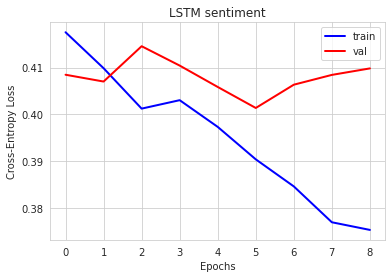

In [ ]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

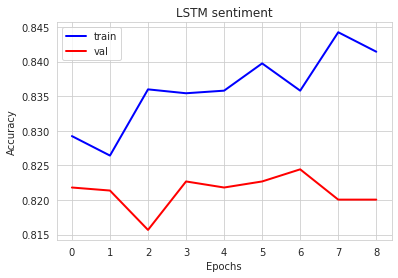

In [ ]:

plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# prediction


In [ ]:

predictions = model.predict_classes(word_seq_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:

from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix, confusion_matrix

In [ ]:
target_names = ["fack", "real"]

In [ ]:
submission_5= pd.DataFrame(predictions, columns=['target'])
submission_5['id'] = test['id']
submission_5.set_index('id', inplace=True)

submission_5.to_csv('submission_5.csv',index=True)
submission_5.head

<bound method NDFrame.head of        target
id           
0           1
2           1
3           1
9           1
11          1
...       ...
10861       1
10865       1
10868       1
10874       1
10875       0

[3263 rows x 1 columns]>

In [ ]:
submission_5=pd.read_csv('test_dat.csv')
submission_5['pred']= (predictions>0.5).astype(int)
submission_5[['pred', "target"]]

In [ ]:
import sklearn

print("Accuracy With fastText :")
print(sklearn.metrics.accuracy_score(submission_5.target, submission_5.pred))

Accuracy With fastText :
1.0


In [ ]:

fake_tweets = train[train.target == 0]
fake_tweets.shape

(4342, 6)

# cross table


In [ ]:
# Check Model Performance
accuracy, cf_matrix, precision, recall =predictions
print('Accuracy: {} Precision: {} Recall: {}'.format(accuracy, precision, recall))

In [ ]:
#predictions = model.predict_classes(word_seq_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(word_seq_test, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))

# glove model


In [ ]:
import requests, zipfile, io
zip_file_url = "https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
https://wikipedia2vec.s3-ap-northeast-1.amazonaws.com/misc/text_classification/enwiki_20180420_lg1_300d.pkl.bz2

In [ ]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
#from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

952it [00:00, 9512.03it/s]

loading word embeddings...


2196019it [03:31, 10392.53it/s]

found 2196017 word vectors


In [ ]:
#load the data
#load the triannig data
train_1 = pd.read_csv("/content/drive/MyDrive/nlp_tweeter/train.csv")
test_1 = pd.read_csv("/content/drive/MyDrive/nlp_tweeter/test.csv")
print("Number of training data ", train.shape[0])
print("Number of testing data: ", test.shape[0])

Number of training data  7613
Number of testing data:  3263


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


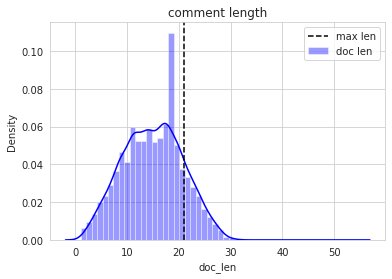

In [ ]:
label_names_1 = ["target"]
y_train_1 = train[label_names_1].values
train_1['doc_len'] = train_1['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_1['doc_len'].mean() + train['doc_len'].std()).astype(int)

sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [ ]:
from sklearn.utils import shuffle 

raw_docs_train = train_1['text'].tolist()
raw_docs_test = test_1['text'].tolist() 
num_classes = len(label_names_1)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  7%|▋         | 554/7613 [00:00<00:01, 5527.50it/s]

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 4970.36it/s]


tokenizing input data...
dictionary size:  28717


In [ ]:
#training params
batch_size = 250
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 13000


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 20))

sample words not found:  ["'as" 'awesomejobsiri' 'gududaz4fx' "'reunion" '0c1y8g7e9p' 'aawzxykles'
 'wc69xajis4' 'tookitlikeaman' '\x89û÷muslim' '41l8tqcaey'
 'abbruchsimulator' 'tanstaafl23' 'jxhazebnqk' 'qgk64ypn13' 'ngehhg9yga'
 'sammysosita' 'x9mdhocpda' 'nyorks' "'demolish" 'cg9gakbpta']


In [ ]:

# we don't want the model to overwrite
keras.backend.clear_session()

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_glove = tf.keras.Sequential()

model_glove.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_glove.add(Bidirectional(LSTM(32)))
model_glove.add(Dense(32,activation='relu'))
model_glove.add(Dropout(0.3))
model_glove.add(Dense(1,activation='sigmoid'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           8615400   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,702,761
Trainable params: 87,361
Non-trainable params: 8,615,400
_________________________________________________________________


In [ ]:

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
model_glove.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
es_callback = EarlyStopping(monitor='vol_loss',patience=3)
history_glove = model_glove.fit(word_seq_train,y_train_1,batch_size=250,
                                epochs=num_epochs, validation_split=0.3, callbacks=[es_callback],shuffle=False)


Epoch 1/40
22/22 [==============================] - 5s 45ms/step - loss: 0.6511 - accuracy: 0.6313 - val_loss: 0.5683 - val_accuracy: 0.7198
Epoch 2/40
22/22 [==============================] - 0s 12ms/step - loss: 0.5439 - accuracy: 0.7472 - val_loss: 0.4814 - val_accuracy: 0.7719
Epoch 3/40
22/22 [==============================] - 0s 12ms/step - loss: 0.4704 - accuracy: 0.7955 - val_loss: 0.4580 - val_accuracy: 0.7942
Epoch 4/40
22/22 [==============================] - 0s 12ms/step - loss: 0.4395 - accuracy: 0.8082 - val_loss: 0.4497 - val_accuracy: 0.7995
Epoch 5/40
22/22 [==============================] - 0s 13ms/step - loss: 0.4167 - accuracy: 0.8229 - val_loss: 0.4462 - val_accuracy: 0.7990
Epoch 6/40
22/22 [==============================] - 0s 13ms/step - loss: 0.3957 - accuracy: 0.8334 - val_loss: 0.4518 - val_accuracy: 0.7982
Epoch 7/40
22/22 [==============================] - 0s 11ms/step - loss: 0.3775 - accuracy: 0.8469 - val_loss: 0.4530 - val_accuracy: 0.8030
Epoch 8/40
22

In [ ]:
predictions = model_glove.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)

In [ ]:
import requests, zipfile, io
zip_file_url = "https://wikipedia2vec.s3-ap-northeast-1.amazonaws.com/misc/text_classification/enwiki_20180420_lg1_300d.pkl.bz2"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()